# **Data Cleaning**

### 1. Accessing the Database

In [67]:
# Import  data
import sqlalchemy as db
from sqlalchemy import create_engine
import os 
from dotenv import load_dotenv 

# Manipulating the data
import pandas as pd
import warnings
import seaborn as sns
import json

# Plotting and Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

warnings.filterwarnings(action = 'ignore')


In [15]:
# Access the Database 
# Load and get credentials from the environment 
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name_raw = os.getenv("DB_RAW")

# Connection string
connection_string = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:3306/db_olist_raw"

# Create SQLAlchemy engine 
try:
    engine = db.create_engine(connection_string)
    print(f"Connection to 'db_olist_raw' successful.")
except Exception as e: 
    print(f"Connection failed: {e}")

# Create a connection to the Database
conn = engine.connect()

# Test query 
test_query = "SELECT * FROM customers_dataset LIMIT 5;"
df_test = pd.read_sql(test_query, conn)
        
print("Test query successful:")
display(df_test)

Connection to 'db_olist_raw' successful.
Test query successful:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,41016,Covington,Kentucky\r
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,10546,Millwood,New York\r
2,0001fd6190edaaf884bcaf3d49edf079,94b11d37cd61cb2994a194d11f89682b,62279,Renault,Illinois\r
3,0002414f95344307404f0ace7a26f1d5,4893ad4ea28b2c5b3ddf4e82e79db9e6,04742,Fort Fairfield,Maine\r
4,000379cdec625522490c315e70c7a9fb,0b83f73b19c2019e182fd552c048a22c,41016,Covington,Kentucky\r


In [3]:
# Create a def function to run query using MySQL syntax 
def run_query(query,conn):
    df = pd.read_sql(query,conn)
    display(df)
    return df

In [12]:
# Get the list of tables from the database 
with engine.connect() as conn: 
    table_names_query = "SHOW TABLES;"
    table_names = pd.read_sql(table_names_query, conn).iloc[:,0].tolist()
print(f"Found {len(table_names)} tables: {table_names}")

Found 9 tables: ['customers_dataset', 'geolocation_dataset', 'order_items_dataset', 'order_payments_dataset', 'order_reviews_dataset', 'orders_dataset', 'product_category_name_translation', 'products_dataset', 'sellers_dataset']


In [5]:
# Loop through the list of table names and load them into a dictionary 
table_dict = {}
with engine.connect() as conn:
    for table in table_names:
        query = f"SELECT * FROM {table};"
        table_dict[table] = pd.read_sql(query,conn)
print(f"All table from {db_name_raw} database have been loaded into the 'table_dict' dictionary")

All table from db_olist_raw database have been loaded into the 'table_dict' dictionary


In [62]:
# Assign the dataframes to variables 
customers_df = table_dict['customers_dataset']
geolocation_df = table_dict['geolocation_dataset']
order_items_df = table_dict['order_items_dataset']
order_payment_df = table_dict['order_payments_dataset']
order_review_df = table_dict['order_reviews_dataset']
orders_df = table_dict['orders_dataset']
product_name_eng = table_dict['product_category_name_translation']
product_df = table_dict['products_dataset']
sellers_df = table_dict['sellers_dataset'] 

In [11]:
# Build the connection for ipython-sql
sql_magic_conn_string = f"mysql+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_raw}"

%load_ext sql 
%sql $sql_magic_conn_string

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### 2. Examine the datasets 

In [79]:
# Create a function to examine the data
def examine_data(df):
    """ Function to examine the data and summarize the results in a table format."""
    total_rows = len(df)
    
    # Handle empty DataFrame case
    if total_rows == 0:
        return pd.DataFrame({
            'rows_count': [0],
            'rows_with_nulls': [0],
            'unique' : [False],
            'cardinality': [0],
            'with_nulls': [False],
            'null_%': [0],
            '1st_row': [None],
            'last_row': [None],
            'random_row': [None],
            'data_type': [None]
        })

    result = pd.DataFrame({
        'rows_count': [total_rows] * df.shape[1],
        'rows_with_nulls': df.isnull().sum(),
        'unique' : df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_nulls': df.isnull().any(),
        'null_%': round((df.isnull().sum()/total_rows * 100),1),
        '1st_row': df.iloc[0],
        'last_row': df.iloc[-1],
        'random_row': df.sample(1).iloc[0],
        'data_type': df.dtypes
    })

    return result

In [9]:
# 1. Examine the "customers table"
examine_customers_dataset = examine_data(customers_df)
display(examine_customers_dataset)
display(customers_df)

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
customer_id,99441,0,True,99441,False,0.0,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99,84f82d5d361c6b6ae90f6de02256702c,object
customer_unique_id,99441,0,False,96096,False,0.0,248ffe10d632bebe4f7267f1f44844c9,736e6bfa0510aa5b878881a226a5fd89,40418d42f6fe097b451c29318f01e357,object
customer_zip_code_prefix,99441,0,False,5841,False,0.0,41016,85305,39756,object
customer_city,99441,0,False,3781,False,0.0,Covington,Glendale,Prairie,object
customer_state,99441,0,False,25,False,0.0,Kentucky\r,Arizona\r,Mississippi\r,object


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,41016,Covington,Kentucky\r
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,10546,Millwood,New York\r
2,0001fd6190edaaf884bcaf3d49edf079,94b11d37cd61cb2994a194d11f89682b,62279,Renault,Illinois\r
3,0002414f95344307404f0ace7a26f1d5,4893ad4ea28b2c5b3ddf4e82e79db9e6,04742,Fort Fairfield,Maine\r
4,000379cdec625522490c315e70c7a9fb,0b83f73b19c2019e182fd552c048a22c,41016,Covington,Kentucky\r
...,...,...,...,...,...
99436,fffecc9f79fd8c764f843e9951b11341,e5794df8573fa179a90a7b797fc4b71f,63933,Campbell,Missouri\r
99437,fffeda5b6d849fbd39689bb92087f431,afbb5a642107cf6bb1ca68e863175f03,86438,Yucca,Arizona\r
99438,ffff42319e9b2d713724ae527742af25,680213db6ebd9e4f24d03280cbe10346,65053,Lohman,Missouri\r
99439,ffffa3172527f765de70084a7e53aae8,48fd7dec70f2b104a1d5e8c5c639102b,27343,Semora,North Carolina\r


In [ ]:
# 2. Examine the "orders table"
examine_orders_dataset = examine_data(orders_df)
display(examine_orders_dataset)
display(orders_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
order_id,99441,0,True,99441,False,0.0,e481f51cbdc54678b7cc49136f2d6af7,66dea50a8b16d9b4dee7af250b4be1a5,1299a512fc464f808332d44a0e73f367,object
customer_id,99441,0,True,99441,False,0.0,9ef432eb6251297304e76186b10a928d,edb027a75a1449115f6b43211ae02a24,03607aa94cc886c288008326808df435,object
order_status,99441,0,False,8,False,0.0,delivered,delivered,delivered,object
order_purchase_timestamp,99441,0,False,98875,False,0.0,2017-10-02 10:56:33,2018-03-08 20:57:30,2017-03-19 15:21:25,datetime64[ns]
order_approved_at,99441,160,False,90733,True,0.2,2017-10-02 11:07:15,2018-03-09 11:20:28,2017-03-19 15:21:25,datetime64[ns]
order_delivered_carrier_date,99441,1783,False,81018,True,1.8,2017-10-04 19:55:00,2018-03-09 22:11:59,2017-03-24 13:38:41,datetime64[ns]
order_delivered_customer_date,99441,2965,False,95664,True,3.0,2017-10-10 21:25:13,2018-03-16 13:08:30,2017-04-01 10:53:57,datetime64[ns]
order_estimated_delivery_date,99441,0,False,459,False,0.0,2017-10-18 00:00:00,2018-04-03 00:00:00,2017-04-20 00:00:00,datetime64[ns]


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [16]:
# find the earliest and latest date in the datasets
query_min_max_date = """
                    SELECT 'order_purchase_timestamp' as purchase_time, 
                            MIN(order_purchase_timestamp) as earliest_date, 
                            MAX(order_purchase_timestamp) as lastest_date 
                    FROM orders_dataset 
                    WHERE order_purchase_timestamp > '2000-01-01'
                    UNION ALL 
                    SELECT 'order_approved_at' as order_approve_time,
                            MIN(order_approved_at) as earliest_date,
                            MAX(order_approved_at) as lastest_date
                    FROM orders_dataset
                    WHERE order_approved_at > '2000-01-01'
                    UNION ALL 
                    SELECT 'order_delivered_carrier_date' as carried_date,
                            MIN(order_delivered_carrier_date) as earliest_date,
                            MAX(order_delivered_carrier_date) as lastest_date
                    FROM orders_dataset
                    WHERE order_delivered_carrier_date > '2000-01-01'
                    UNION ALL 
                    SELECT 'order_delivered_customer_date' as delivered_date,
                            MIN(order_delivered_customer_date) as earliest_date,
                            MAX(order_delivered_customer_date) as lastest_date
                    FROM orders_dataset
                    WHERE order_delivered_customer_date > '2000-01-01'
                    UNION ALL 
                    SELECT 'order_estimated_delivery_date' as estimated_deliver_date,
                            MIN(order_estimated_delivery_date) as earliest_date,
                            MAX(order_estimated_delivery_date) as lastest_date
                    FROM orders_dataset
                    WHERE order_estimated_delivery_date > '2000-01-01'
                    ;
                    """
min_max_date_df = pd.read_sql(query_min_max_date,conn)
display(min_max_date_df)

,purchase_time,earliest_date,lastest_date
0,order_purchase_timestamp,2016-09-04 21:15:19,2018-10-17 17:30:18
1,order_approved_at,2016-09-15 12:16:38,2018-09-03 17:40:06
2,order_delivered_carrier_date,2016-10-08 10:34:01,2018-09-11 19:48:28
3,order_delivered_customer_date,2016-10-11 13:46:32,2018-10-17 13:22:46
4,order_estimated_delivery_date,2016-09-30 00:00:00,2018-11-12 00:00:00


The dataset contains records from 2016-09-04 to 2018-11-12

In [ ]:
# 3. Examine the "geolocation table"
examine_geo_dataset = examine_data(geolocation_df)
display(examine_geo_dataset)
display(geolocation_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
geolocation_zip_code_prefix,2000326,0,False,6498,False,0.0,03304,84326,97039,object
geolocation_lat,2000326,0,False,1000163,False,0.0,43.129723,41.674383,45.475542,float64
geolocation_lng,2000326,0,False,1000163,False,0.0,-71.527521,-111.816504,-120.620244,float64
geolocation_city,2000326,0,False,4120,False,0.0,Bow,Millville,Moro,object
geolocation_state,2000326,0,False,26,False,0.0,New Hampshire\r,Utah\r,Oregon\r,object


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,03304,43.129723,-71.527521,Bow,New Hampshire\r
1,53190,42.809631,-88.727142,Whitewater,Wisconsin\r
2,14028,43.314741,-78.717849,Burt,New York\r
3,70534,30.162003,-92.454649,Estherwood,Louisiana\r
4,64752,38.072689,-94.568662,Hume,Missouri\r


In [ ]:
# 4. Examine the "order item table"
examine_order_item_dataset = examine_data(order_items_df)
display(examine_order_item_dataset)
display(order_items_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
order_id,225300,0,False,98666,False,0.0,"""00010242fe8c5a6d1ba2dd792cb16214""",fffe41c64501cc87c801fd61db3f6244,"""442693e8e705ad1f9c91f762f0d297bc""",object
order_item_id,225300,0,False,21,False,0.0,1,1,1,int64
product_id,225300,0,False,32951,False,0.0,"""4244733e06e7ecb4970a6e2683c13e61""","""350688d9dc1e75ff97be326363655e01""",bc4cd4da98dd128c39bf0b8c2674032f,object
seller_id,225300,0,False,3095,False,0.0,"""48436dade18ac8b2bce089ec2a041202""",f7ccf836d21b2fb1de37564105216cc1,"""53243585a1d6dc2643021fd1853d8905""",object
shipping_limit_date,225300,0,False,93318,False,0.0,2017-09-19 09:45:35,2018-06-12 17:10:13,2017-09-03 21:25:14,datetime64[ns]
price,225300,0,False,5968,False,0.0,58.9,43.0,1200.0,float64
freight_value,225300,0,False,6999,False,0.0,13.29,12.79,50.81,float64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,"""00010242fe8c5a6d1ba2dd792cb16214""",1,"""4244733e06e7ecb4970a6e2683c13e61""","""48436dade18ac8b2bce089ec2a041202""",2017-09-19 09:45:35,58.90,13.29
1,"""00018f77f2f0320c557190d7a144bdd3""",1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,"""000229ec398224ef6ca0657da4fc703e""",1,c777355d18b72b67abbeef9df44fd0fd,"""5b51032eddd242adc84c38acab88f23d""",2018-01-18 14:48:30,199.00,17.87
3,"""00024acbcdf0a6daa1e931b038114c75""",1,"""7634da152a4610f1595efa32f14722fc""","""9d7a1d34a5052409006425275ba1c2b4""",2018-08-15 10:10:18,12.99,12.79
4,"""00042b26cf59d7ce69dfabb4e55b4fd9""",1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
# 5. Examine the "seller table"
examine_sellers_dataset = examine_data(sellers_df)
display(examine_sellers_dataset)
display(sellers_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
seller_id,3095,0,True,3095,False,0.0,0015a82c2db000af6aaaf3ae2ecb0532,ffff564a4f9085cd26170f4732393726,6c9875b2f94ba781186f0c1aed8d1687,object
seller_zip_code_prefix,3095,0,False,1914,False,0.0,28732,10566,40014,object
seller_city,3095,0,False,1470,False,0.0,Fletcher,Peekskill,Crestwood,object
seller_state,3095,0,False,24,False,0.0,North Carolina\r,New York\r,Kentucky\r,object


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0015a82c2db000af6aaaf3ae2ecb0532,28732,Fletcher,North Carolina\r
1,001cca7ae9ae17fb1caed9dfb1094831,70341,Belle Rose,Louisiana\r
2,001e6ad469a905060d959994f1b41e4f,60649,Chicago,Illinois\r
3,002100f778ceb8431b7a1020ff7ab48f,61072,Rockton,Illinois\r
4,003554e2dce176b5555353e4f3555ac8,57319,Bridgewater,South Dakota\r


In [ ]:
# 6. Examine the "order payment table"
examine_order_payment_dataset = examine_data(order_payment_df)
display(examine_order_payment_dataset)
display(order_payment_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
order_id,207772,0,False,99440,False,0.0,b81ef226f3fe1789b1e8b2acac839d17,"""28bbae6599b09d39ca406b747b6632b1""",e3234cd6072b07fce570475325d2ca5f,object
payment_sequential,207772,0,False,29,False,0.0,1,1,1,int64
payment_type,207772,0,False,5,False,0.0,credit_card,boleto,boleto,object
payment_installments,207772,0,False,24,False,0.0,8,1,1,int64
payment_value,207772,0,False,29077,False,0.0,99.33,191.58,129.57,float64


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,"""25e8ea4e93396b6fa0d3dd708e76c1bd""",1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,"""42fdf880ba16b47b59251dd489d4441a""",1,credit_card,2,128.45


In [63]:
# 7. Examine the "order review table"
examine_order_review_dataset = examine_data(order_review_df)
display(examine_order_review_dataset)
display(order_review_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
review_id,396892,0,False,98409,False,0.0,7bc2406110b926393aa56f80a40eba40,efe49f1d6f951dd88b51e6ccd4cc548f,3395811f3eb668164284d1f997b5defd,object
order_id,396892,0,False,98672,False,0.0,73fc7af87114b39712e6da79b0a377eb,90531360ecb1eec2a1fbb265a0db0508,8864fa647f9775d125c8a17ec0e33789,object
review_score,396892,0,False,5,False,0.0,4,1,1,int64
review_comment_title,396892,0,False,4528,False,0.0,,,,object
review_comment_message,396892,0,False,36042,False,0.0,,"meu produto chegou e ja tenho que devolver, po...",,object
review_creation_date,396892,4,False,636,True,0.0,2018-01-18 00:00:00,2017-07-03 00:00:00,2018-05-01 00:00:00,datetime64[ns]
review_answer_timestamp,396892,4,False,98246,True,0.0,2018-01-18 21:46:59,2017-07-03 21:01:49,2018-05-02 12:00:44,datetime64[ns]


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,,,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,,,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,,,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [14]:
# 8. Examine the "order product table"
examine_order_item_dataset = examine_data(product_df)
display(examine_order_item_dataset)
display(product_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
product_id,32951,0,True,32951,False,0.0,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58,97ac99fefa9cf4eb8f825136a89e8f40,object
product_category_name,32951,0,False,74,False,0.0,perfumaria,brinquedos,telefonia,object
product_name_lenght,32951,610,False,66,True,1.9,53.0,57.0,63.0,float64
product_description_lenght,32951,610,False,2960,True,1.9,596.0,1536.0,3883.0,float64
product_photos_qty,32951,610,False,19,True,1.9,6.0,3.0,1.0,float64
product_weight_g,32951,2,False,2204,True,0.0,300.0,3900.0,370.0,float64
product_length_cm,32951,2,False,99,True,0.0,20.0,43.0,17.0,float64
product_height_cm,32951,2,False,102,True,0.0,16.0,16.0,6.0,float64
product_width_cm,32951,2,False,95,True,0.0,16.0,11.0,11.0,float64


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,53.0,596.0,6.0,300.0,20.0,16.0,16.0
1,00088930e925c41fd95ebfe695fd2655,automotivo,56.0,752.0,4.0,1225.0,55.0,10.0,26.0
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,50.0,266.0,2.0,300.0,45.0,15.0,35.0
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,25.0,364.0,3.0,550.0,19.0,24.0,12.0
4,000d9be29b5207b54e86aa1b1ac54872,relogios_presentes,48.0,613.0,4.0,250.0,22.0,11.0,15.0


In [18]:
# 9. Examine the "english product name table"
examine_product_eng_name = examine_data(product_name_eng)
display(examine_product_eng_name)
display(product_name_eng.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
product_category_name,71,0,True,71,False,0.0,agro_industria_e_comercio,utilidades_domesticas,portateis_casa_forno_e_cafe,object
product_category_name_english,71,0,True,71,False,0.0,agro_industry_and_commerce,housewares,small_appliances_home_oven_and_coffee,object


,product_category_name,product_category_name_english
0,agro_industria_e_comercio,agro_industry_and_commerce
1,alimentos,food
2,alimentos_bebidas,food_drink
3,artes,art
4,artes_e_artesanato,arts_and_craftmanship


### 3. Data Cleaning 

Remove the "" in the `order_id` of tables which have `order_id` 

In [147]:
# Create a list of order related tables and loop through the list to remove the "" in the order_id columns
order_table_list = (order_items_df,order_payment_df,order_review_df,orders_df)

for table in order_table_list:
    table.drop_duplicates(inplace=True)
    table['order_id'] = table['order_id'].str.replace('"','',regex=False)
 

### 3.1 Cleaning the "Product" table

In [148]:
# 1. Clean the product table and metadata
# Remove "\r" from the "product_category_name_english" strings values 
product_name_eng['product_category_name_english'] = product_name_eng['product_category_name_english'].str.replace('\r','',regex=False)


In [149]:
# Merge english product name to product tables 
product_cleaned_df = product_df.copy()
product_cleaned_df = pd.merge(product_cleaned_df,product_name_eng,how="left")

# Replace the orginical product_category_name to english name
product_cleaned_df = product_cleaned_df.drop(columns=['product_category_name'])
product_cleaned_df = product_cleaned_df.rename(columns={'product_category_name_english':'product_category_name'})
product_cleaned_df = product_cleaned_df[['product_id','product_category_name','product_name_lenght',
                                         'product_description_lenght','product_photos_qty','product_weight_g',
                                         'product_length_cm','product_height_cm','product_width_cm']]

In [150]:
# Change the type of the measurements columns to integer 
measure_col_list = ['product_name_lenght','product_description_lenght',
                    'product_photos_qty','product_weight_g','product_length_cm',
                    'product_height_cm','product_width_cm']
product_cleaned_df[measure_col_list] = product_cleaned_df[measure_col_list].astype('Int64')

#### 3.2 Cleaning the "Customers" table

In [151]:
# 2. Clean the "customer table"
# Remove "\r" from the "customer_state" strings values
customers_cleaned_df = customers_df.copy()
customers_cleaned_df['customer_state'] = customers_cleaned_df['customer_state'].str.replace('\r','',regex=False)

# Remove '""' in the id column if available 
customers_cleaned_df['customer_id'] = customers_cleaned_df['customer_id'].str.replace('"','',regex=False)

#### 3.3 Cleaning the "Orders" table
This table log the process of orders delivery from purchase confirmation, order approval to delivery date, there're missing values from the timestamp columns which need to be evaluated.

In [152]:
# The order status 
order_status_query = "SELECT DISTINCT(order_status) as order_status FROM orders_dataset;"
order_status_list = run_query(order_status_query,conn)

,order_status
0,delivered
1,invoiced
2,shipped
3,processing
4,unavailable
5,canceled
6,created
7,approved


In [153]:
# Create a def function to summarize the number of order by order_status with no timestamp
targeted_columns = ['order_delivered_carrier_date','order_approved_at',
                      'order_delivered_customer_date']

def null_order(df,targeted_columns ,col):
    # Decode the columns containing timestamp by replacing null with 0 and non-null with 1
    timestamp_col_list = ['order_approved_at','order_delivered_carrier_date','order_purchase_timestamp',
                      'order_delivered_customer_date','order_estimated_delivery_date']
    decoded_df = df.copy()
    decoded_df[timestamp_col_list] = decoded_df[timestamp_col_list].notna().astype(int)
    
    # Filter the dataframe with null value of the selected column
    filtered_df = decoded_df[decoded_df[col] == 0]
    
    # Summarize filtered dataframe 
    group_columns = targeted_columns.copy()
    group_columns.remove(col)
    group_list = ['order_status'] + group_columns
    group_df = filtered_df.groupby(group_list)['order_id'].count().reset_index(name='order_nb')
    
    # # Re-arrange columns for easier visibility
    # group_list.append('order_nb')
    # group_df = group_df[[group_list]]
    
    print(f'Examine the orders with null value in "{col}" column:')
    display(group_df)
    return group_df
    
    

In [154]:
# Apply the function for 'order_approved_at'
disapproved_order = null_order(orders_df,targeted_columns,'order_approved_at')

Examine the orders with null value in "order_approved_at" column:


,order_status,order_delivered_carrier_date,order_delivered_customer_date,order_nb
0,canceled,0,0,141
1,created,0,0,5
2,delivered,1,1,14


Actions:
- Remove 5 rows of 'created' orders but no follow up process since these are not meaningful to the analytic process
- For 14 rows of 'delivered': To preserve these valid orders for analysis, I imputed the missing `order_approved_at` time with the corresponding `order_purchase_timestamp` under the assumption that there might be random errors occured when inputing the `order_approved_at` value for these rows


In [155]:
orders_cleaned_df = orders_df.copy()
# Remove 5 rows of 'created' orders but no follow up process
rows_deleted =len(orders_cleaned_df[(orders_cleaned_df['order_status'] == 'created') 
                                      & (orders_cleaned_df['order_approved_at'].isnull())])
 
orders_cleaned_df = orders_cleaned_df[~((orders_cleaned_df['order_status'] == 'created') 
                                      & (orders_cleaned_df['order_approved_at'].isnull()))]


print(f"Remove {rows_deleted} from the dataset")

Remove 5 from the dataset


In [156]:
# Remove 14 abnormal rows 
condition = ((orders_cleaned_df['order_status'] == 'delivered') &
             (orders_cleaned_df['order_approved_at'].isnull()))

# Get the 'order_purchase_timestamp' for just those 14 rows
imputed_time = orders_cleaned_df.loc[condition,'order_purchase_timestamp']

# Fill the null values with the corresponding purchase time
imputed_time = orders_cleaned_df.loc[condition,'order_purchase_timestamp']

# Verification 
# print("Before Imputation:")
# org_disapproved_order = orders_df[condition]['order_approved_at'].isnull().sum()
# print(f"Null 'approved_at' for 'delivered' orders: {org_disapproved_order}")

print("\n After Imputation")
new_disapproved_order = orders_cleaned_df[condition]['order_approved_at'].isnull().sum()
print(f"Null 'approved_at' for 'delivered' orders: {new_disapproved_order}")



 After Imputation
Null 'approved_at' for 'delivered' orders: 14


In [157]:
# Apply the function to `order_delivered_carrier_date` column
no_carrier_deliver = null_order(orders_cleaned_df,targeted_columns,'order_delivered_carrier_date')

Examine the orders with null value in "order_delivered_carrier_date" column:


,order_status,order_approved_at,order_delivered_customer_date,order_nb
0,approved,1,0,2
1,canceled,0,0,141
2,canceled,1,0,409
3,delivered,1,0,1
4,delivered,1,1,1
5,invoiced,1,0,314
6,processing,1,0,301
7,unavailable,1,0,609


**Data cleaning strategy**
- Impute Row 4 (marked as "delivered" to customers but no carrirer date): fill null value with the order_approved_at timestamp.
- Remove Row 3 (marked as "delivered" but no record of deliver time): deemed as unstrustworthy record.

In [158]:
# Impute rows marked as "delivered" to customers but missing carrirer date
condition_4th_row = (
                    (orders_cleaned_df['order_status'] == 'delivered') &
                    (orders_cleaned_df['order_delivered_carrier_date'].isnull()) &
                    (orders_cleaned_df['order_delivered_customer_date'].notnull())
                    )

# Fill the missing carrier date with the approval time
imputed_time = orders_cleaned_df.loc[condition_4th_row.values,'order_approved_at']
orders_cleaned_df.loc[condition_4th_row.values,'order_delivered_carrier_date'] = imputed_time

print(f"Repaired {imputed_time.shape[0]} order by imputing carrier date.")

# Exclude the Untrustworthy Row 
condition_3rd_row = (
                    (orders_cleaned_df['order_status'] == 'delivered') &
                    (orders_cleaned_df['order_delivered_carrier_date'].isnull()) &
                    (orders_cleaned_df['order_delivered_customer_date'].isnull())
                    )

# Drop the row(s) with their indexes
excluded_rows = orders_cleaned_df[condition_3rd_row]
excluded_rows_nb = orders_cleaned_df[condition_3rd_row].index

orders_cleaned_df = orders_cleaned_df.drop(excluded_rows_nb)

print(f"Excluded {len(excluded_rows_nb)} untrustworthy 'delivered' order(s).")

Repaired 1 order by imputing carrier date.
Excluded 1 untrustworthy 'delivered' order(s).


In [159]:
# Apply the function to `order_delivered_carrier_date` column
no_deliver_date = null_order(orders_cleaned_df,targeted_columns,'order_delivered_customer_date')

Examine the orders with null value in "order_delivered_customer_date" column:


,order_status,order_delivered_carrier_date,order_approved_at,order_nb
0,approved,0,1,2
1,canceled,0,0,141
2,canceled,0,1,409
3,canceled,1,1,69
4,delivered,1,1,7
5,invoiced,0,1,314
6,processing,0,1,301
7,shipped,1,1,1107
8,unavailable,0,1,609


**Data cleaning strategy**
Remove Row 4: This row represents 7 orders labeled as "delivered" without any recorded delivery timestamp. The absence of delivery confirmation suggests these entries may be unreliable and potentially misclassified due to status assignment errors.


In [160]:
# Exclude the above unstrustworthy rows 
error_deliver_status = orders_cleaned_df[((orders_cleaned_df['order_status'] == "delivered") &
                                         (orders_cleaned_df['order_delivered_customer_date'].isnull()))
                                         ]

excluded_rows_nb = orders_cleaned_df[((orders_cleaned_df['order_status'] == "delivered") &
                                         (orders_cleaned_df['order_delivered_customer_date'].isnull()))
                                         ].index


# 3. Drop the row(s)
if len(excluded_rows_nb) > 0:
    orders_cleaned_df = orders_cleaned_df.drop(excluded_rows_nb)
    print(f"Excluded {len(excluded_rows_nb)} untrustworthy 'delivered' orders with NULL delivery dates.")
else:
    print("No anomalous rows found to exclude.")

Excluded 7 untrustworthy 'delivered' orders with NULL delivery dates.


#### 3.4 Clean the "Order payments" and "Order review" table

In [161]:
# Examine the "order review"
examine_order_review_dataset = examine_data(order_review_df)
display(examine_order_review_dataset)

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
review_id,99223,0,False,98409,False,0.0,7bc2406110b926393aa56f80a40eba40,efe49f1d6f951dd88b51e6ccd4cc548f,72f992f34d1ccc512ce2ca96f56a3603,object
order_id,99223,0,False,98672,False,0.0,73fc7af87114b39712e6da79b0a377eb,90531360ecb1eec2a1fbb265a0db0508,a1cfeb76f1be888dfc371fbd47344141,object
review_score,99223,0,False,5,False,0.0,4,1,5,int64
review_comment_title,99223,0,False,4528,False,0.0,,,,object
review_comment_message,99223,0,False,36042,False,0.0,,"meu produto chegou e ja tenho que devolver, po...",,object
review_creation_date,99223,1,False,636,True,0.0,2018-01-18 00:00:00,2017-07-03 00:00:00,2017-07-06 00:00:00,datetime64[ns]
review_answer_timestamp,99223,1,False,98246,True,0.0,2018-01-18 21:46:59,2017-07-03 21:01:49,2017-07-07 12:35:58,datetime64[ns]


In [162]:
# Review the null value rows of review creation date and answer date 
display(
    order_review_df[((order_review_df['review_creation_date'].isnull()) |
                    (order_review_df['review_answer_timestamp'].isnull()))]
        )

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
77916,636b237e87574ba29654deaba9eb9797,d7361a834a2dd8db2f6f133ce291ab6b,2,,"foi escrito que o produto já foi entregue, mas...",NaT,NaT


In [163]:
order_review_cleaned = order_review_df.copy()

# Exclude reviews with no creation or comment date due to the assumption that these are erroneous record 
exclude_condition = ((order_review_df['review_creation_date'].isnull()) &
                    (order_review_df['review_answer_timestamp'].isnull()))

# Remove these rows with index
error_reviews = order_review_cleaned[exclude_condition].index 

if len(exclude_condition) > 0:
    order_review_cleaned = order_review_cleaned.drop(error_reviews)
    print(f"Excluded {len(error_reviews)} rows with null dates.")
else:
    print("No rows with null dates found.")

Excluded 1 rows with null dates.


Summarize this reviews dataset by aggregate the review scores by order_id

In [164]:
# Group by order_id and calculate the mean of review_score
order_avg_score = order_review_cleaned.groupby('order_id')['review_score'].mean().reset_index()

# Rename the new column for clarity
order_avg_score = order_avg_score.rename(columns={'review_score': 'avg_review_score'})

display(order_avg_score)

,order_id,avg_review_score
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0
...,...,...
98666,fffc94f6ce00a00581880bf54a75a037,5.0
98667,fffcd46ef2263f404302a634eb57f7eb,5.0
98668,fffce4705a9662cd70adb13d4a31832d,5.0
98669,fffe18544ffabc95dfada21779c9644f,5.0


##### 3.6 Clean the "Order item" & "Order payment" table

In [165]:
# Examine the "order item"
examine_order_item_dataset = examine_data(order_items_df)
display(examine_order_item_dataset)
display(order_items_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
order_id,112650,0,False,98666,False,0.0,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,610550e46b3a0a7f45723db57f2170f3,object
order_item_id,112650,0,False,21,False,0.0,1,1,1,int64
product_id,112650,0,False,32951,False,0.0,"""4244733e06e7ecb4970a6e2683c13e61""","""350688d9dc1e75ff97be326363655e01""","""7c1bd920dbdf22470b68bde975dd3ccf""",object
seller_id,112650,0,False,3095,False,0.0,"""48436dade18ac8b2bce089ec2a041202""",f7ccf836d21b2fb1de37564105216cc1,cc419e0650a3c5ba77189a1882b7556a,object
shipping_limit_date,112650,0,False,93318,False,0.0,2017-09-19 09:45:35,2018-06-12 17:10:13,2017-10-26 23:25:44,datetime64[ns]
price,112650,0,False,5968,False,0.0,58.9,43.0,58.99,float64
freight_value,112650,0,False,6999,False,0.0,13.29,12.79,17.66,float64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,"""4244733e06e7ecb4970a6e2683c13e61""","""48436dade18ac8b2bce089ec2a041202""",2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,"""5b51032eddd242adc84c38acab88f23d""",2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,"""7634da152a4610f1595efa32f14722fc""","""9d7a1d34a5052409006425275ba1c2b4""",2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [166]:
order_items_cleaned = order_items_df.copy()
# Replace the '""' in ids columns 
order_items_cleaned[['product_id','seller_id']] = order_items_cleaned[['product_id','seller_id']].apply(lambda col: col.str.replace('"','',regex=False))

display(order_items_cleaned)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [167]:
# Extract the list of payment types 
payment_methods = order_payment_df['payment_type'].unique().tolist()
print(payment_methods)

['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined']


In [168]:
order_payment_cleaned = order_payment_df.copy()

# replace "boleto" with "bank_bill_pay"
order_payment_cleaned = order_payment_cleaned.replace('boleto','bank_bill_pay')


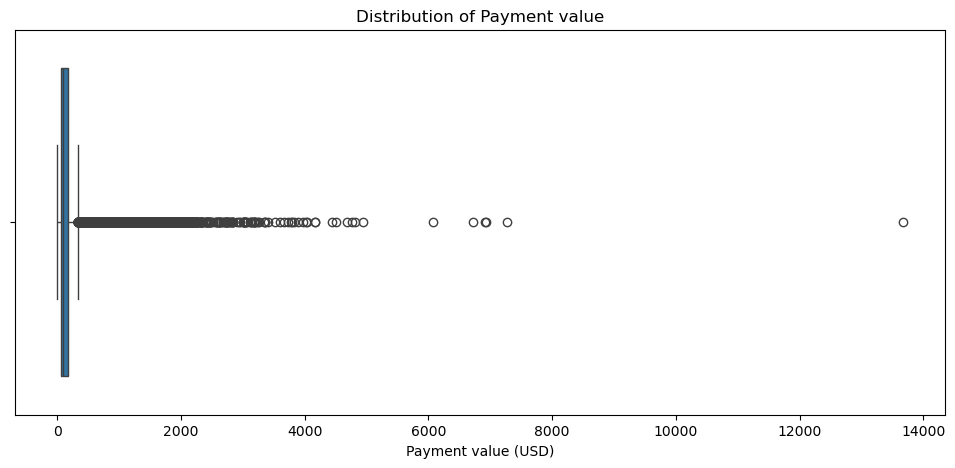

In [169]:
# Plot the distribution chart for the dataset to identify outlier
plt.figure(figsize=(12,5))
sns.boxplot(x=order_payment_cleaned['payment_value'])
plt.title('Distribution of Payment value')
plt.xlabel('Payment value (USD)')
plt.show()

In [170]:
# Examine the orders with payment value over 10000 USD 
outlier_value = order_payment_cleaned[(order_payment_cleaned['payment_value'] > 10000)]
display(outlier_value)

# Extract the order_id of outlier payment value and filter the order_item table 
outlier_value_id = outlier_value['order_id'].unique().tolist()

outlier_item = order_items_cleaned[order_items_cleaned['order_id'].isin(outlier_value_id)]
display(outlier_item)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
52107,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1647,03caa2c082116e1d31e67e9ae3700499,1,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1648,03caa2c082116e1d31e67e9ae3700499,2,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1649,03caa2c082116e1d31e67e9ae3700499,3,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1650,03caa2c082116e1d31e67e9ae3700499,4,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1651,03caa2c082116e1d31e67e9ae3700499,5,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1652,03caa2c082116e1d31e67e9ae3700499,6,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1653,03caa2c082116e1d31e67e9ae3700499,7,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1654,03caa2c082116e1d31e67e9ae3700499,8,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01


Since the payment value aligns with the sales figures from the order_item table, the outlier amount of 13,664.08 USD appears to be legitimate and does not need to be excluded.

##### 3.7 Clean the "Seller" table

In [173]:
sellers_cleaned_df = sellers_df.copy()

# Remove '""' in the id column 
sellers_cleaned_df['seller_id'] = sellers_cleaned_df['seller_id'].str.replace('"','',regex=False)

# Remove '\r' from the string in seller_state
sellers_cleaned_df['seller_state'] = sellers_cleaned_df['seller_state'].str.replace('\r','',regex=False)

display(sellers_cleaned_df)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0015a82c2db000af6aaaf3ae2ecb0532,28732,Fletcher,North Carolina
1,001cca7ae9ae17fb1caed9dfb1094831,70341,Belle Rose,Louisiana
2,001e6ad469a905060d959994f1b41e4f,60649,Chicago,Illinois
3,002100f778ceb8431b7a1020ff7ab48f,61072,Rockton,Illinois
4,003554e2dce176b5555353e4f3555ac8,57319,Bridgewater,South Dakota
...,...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,57566,Parmelee,South Dakota
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,28542,Camp Lejeune,North Carolina
3092,ffeee66ac5d5a62fe688b9d26f83f534,60503,Aurora,Illinois
3093,fffd5413c0700ac820c7069d66d98c89,85139,Maricopa,Arizona
